🦢 착과량 着果量 :
작물에 맺혀 있는 열매의 수량. 과실의 품질 향상을 위해 전정, 적화, 적과 등을 실시하여 열매의 수량을 인위적으로 조절한다.

In [362]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [363]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sub = pd.read_csv('./sample_submission.csv')

In [364]:
train.head()

,ID,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,TRAIN_0000,692,275.0,287.0,292.0,289.5,2.8,2.8,2.7,2.7,...,70.978249,70.876794,70.705253,70.559603,70.427356,70.340491,70.293830,70.262422,70.169841,70.043251
1,TRAIN_0001,534,293.0,284.0,336.0,310.0,3.3,3.3,3.3,3.2,...,71.535483,71.382303,71.253604,71.092665,70.955608,70.796630,70.597550,70.565088,70.560502,70.427600
2,TRAIN_0002,634,300.0,392.0,450.0,421.0,3.0,2.9,2.9,2.9,...,71.279804,71.199570,71.144020,71.026740,70.920038,70.876723,70.710129,70.595971,70.418203,70.399578
3,TRAIN_0003,639,289.0,368.0,379.0,373.5,3.1,3.0,3.0,3.0,...,69.934615,69.884124,69.845683,69.794682,69.779813,69.614644,69.455404,69.281590,69.238689,69.133970
4,TRAIN_0004,496,306.0,353.0,358.0,355.5,3.7,3.6,3.6,3.6,...,68.313016,68.285364,68.209860,68.209458,68.040083,67.859963,67.775556,67.701456,67.504244,67.410093


In [365]:
def make_timeseries(data, what):
    data_list = []
    
    if what == 'train':
        col1 = data.iloc[:,6:95]
        col2 = data.iloc[:,95:]
        
        tcol1 = col1.T
        tcol2 = col2.T
        
        tcol1.columns = data['ID']
        tcol2.columns = data['ID']+str('_1')
        
        tcol1= tcol1.reset_index().drop('index', axis=1)
        tcol2= tcol2.reset_index().drop('index', axis=1)
        
        for id in data['ID']:
            md = pd.concat([tcol1[f'{id}'], tcol2[f'{id}_1']], axis=1)
            md = md.rename(columns = {f'{id}' : '새순', f'{id}_1' : '엽록수'})
            md['ID'] = id
            md['착과량(int)'] = int(data.loc[data['ID'] == id, '착과량(int)'])
            md['수고(m)'] = float(data.loc[data['ID'] == id, '수고(m)'])
            md['수관폭(min)'] = float(data.loc[data['ID'] == id, '수관폭1(min)'])
            md['수관폭(max)'] = float(data.loc[data['ID'] == id, '수관폭2(max)'])
            md['수관폭평균'] = float(data.loc[data['ID'] == id, '수관폭평균'])
              
            data_list.append(md)
            
        td = pd.concat(data_list)
        
        return td
        
    if what == 'test':
        col1 = data.iloc[:,5:94]
        col2 = data.iloc[:,94:]
        
        tcol1 = col1.T
        tcol2 = col2.T
        
        tcol1.columns = data['ID']
        tcol2.columns = data['ID']+str('_1')
        
        tcol1= tcol1.reset_index().drop('index', axis=1)
        tcol2= tcol2.reset_index().drop('index', axis=1)
        
        for id in data['ID']:
            md = pd.concat([tcol1[f'{id}'], tcol2[f'{id}_1']], axis=1)
            md = md.rename(columns = {f'{id}' : '새순', f'{id}_1' : '엽록수'})
            md['ID'] = id
            md['수고(m)'] = float(data.loc[data['ID'] == id, '수고(m)'])
            md['수관폭(min)'] = float(data.loc[data['ID'] == id, '수관폭1(min)'])
            md['수관폭(max)'] = float(data.loc[data['ID'] == id, '수관폭2(max)'])
            md['수관폭평균'] = float(data.loc[data['ID'] == id, '수관폭평균'])
              
            data_list.append(md)
            
        td = pd.concat(data_list)
        
        return td

In [366]:
train = make_timeseries(train, 'train')
test = make_timeseries(test, 'test')

In [367]:
test

,새순,엽록수,ID,수고(m),수관폭(min),수관폭(max),수관폭평균
0,4.3,80.299924,TEST_0000,231.0,219.0,302.0,260.5
1,4.2,80.164425,TEST_0000,231.0,219.0,302.0,260.5
2,4.2,80.113400,TEST_0000,231.0,219.0,302.0,260.5
3,4.1,80.045268,TEST_0000,231.0,219.0,302.0,260.5
4,4.1,79.909461,TEST_0000,231.0,219.0,302.0,260.5
...,...,...,...,...,...,...,...
84,0.6,64.602840,TEST_2207,244.0,380.0,391.0,385.5
85,0.5,64.541821,TEST_2207,244.0,380.0,391.0,385.5
86,0.0,64.367357,TEST_2207,244.0,380.0,391.0,385.5
87,0.0,64.197975,TEST_2207,244.0,380.0,391.0,385.5


In [368]:
train

,새순,엽록수,ID,착과량(int),수고(m),수관폭(min),수관폭(max),수관폭평균
0,2.8,78.336504,TRAIN_0000,692,275.0,287.0,292.0,289.5
1,2.8,78.243462,TRAIN_0000,692,275.0,287.0,292.0,289.5
2,2.7,78.166501,TRAIN_0000,692,275.0,287.0,292.0,289.5
3,2.7,78.127526,TRAIN_0000,692,275.0,287.0,292.0,289.5
4,2.7,78.058021,TRAIN_0000,692,275.0,287.0,292.0,289.5
...,...,...,...,...,...,...,...,...
84,0.6,72.271680,TRAIN_2206,17,228.0,389.0,398.0,393.5
85,0.6,72.208433,TRAIN_2206,17,228.0,389.0,398.0,393.5
86,0.5,72.070977,TRAIN_2206,17,228.0,389.0,398.0,393.5
87,0.0,71.872453,TRAIN_2206,17,228.0,389.0,398.0,393.5


Text(0, 0.5, 'chok')

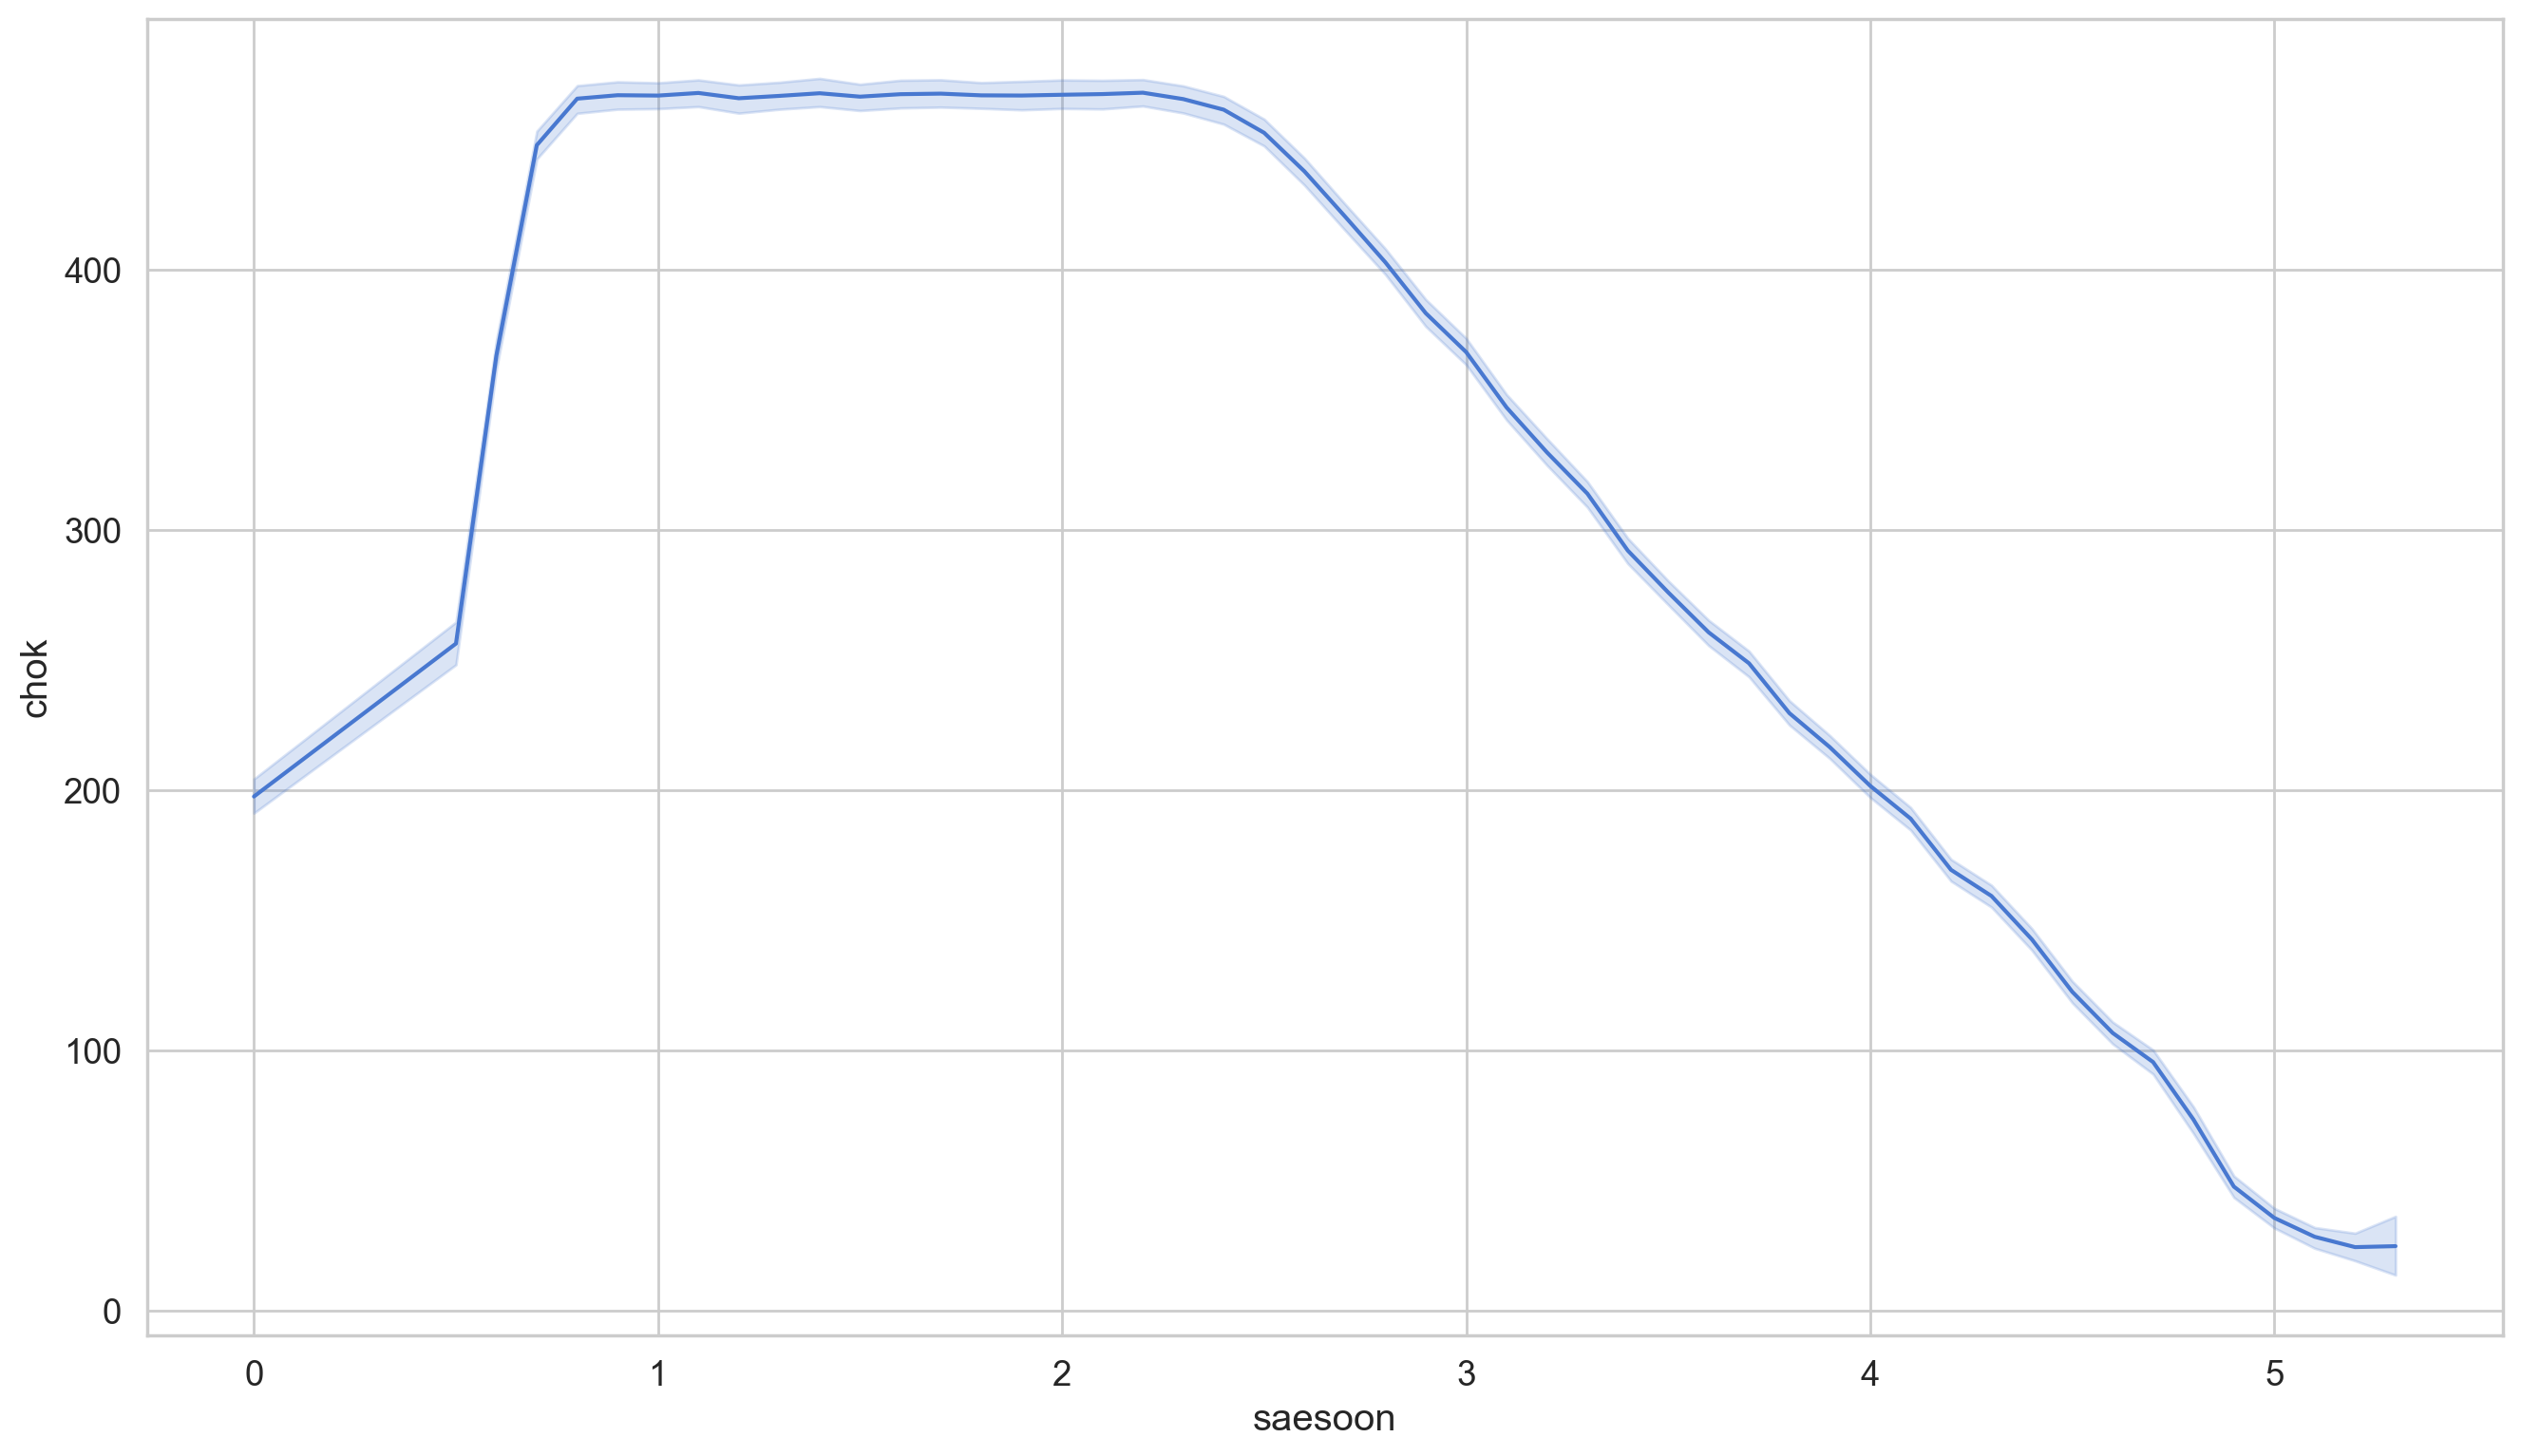

In [372]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=train['착과량(int)'], x=train['새순'])
plt.xlabel('saesoon')
plt.ylabel('chok')

In [377]:
from sklearn.preprocessing import MinMaxScaler

train.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()

scale_cols = ['새순', '엽록수', '착과량(int)', '수고(m)', '수관폭(min)', '수관폭(max)', '수관폭평균']
scale_cols2 = ['새순', '엽록수', '수고(m)', '수관폭(min)', '수관폭(max)', '수관폭평균']

train_scaled = scaler.fit_transform(train[scale_cols])
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns = scale_cols


test_scaled = scaler.fit_transform(test[scale_cols2])
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = scale_cols2


train_scaled

,새순,엽록수,착과량(int),수고(m),수관폭(min),수관폭(max),수관폭평균
0,0.528302,0.663180,0.865915,0.629371,0.413793,0.366594,0.390270
1,0.528302,0.660707,0.865915,0.629371,0.413793,0.366594,0.390270
2,0.509434,0.658662,0.865915,0.629371,0.413793,0.366594,0.390270
3,0.509434,0.657627,0.865915,0.629371,0.413793,0.366594,0.390270
4,0.509434,0.655780,0.865915,0.629371,0.413793,0.366594,0.390270
...,...,...,...,...,...,...,...
196418,0.113208,0.502018,0.020050,0.465035,0.633621,0.596529,0.615135
196419,0.113208,0.500337,0.020050,0.465035,0.633621,0.596529,0.615135
196420,0.094340,0.496684,0.020050,0.465035,0.633621,0.596529,0.615135
196421,0.000000,0.491409,0.020050,0.465035,0.633621,0.596529,0.615135


In [378]:
test_scaled

,새순,엽록수,수고(m),수관폭(min),수관폭(max),수관폭평균
0,0.796296,0.638326,0.383929,0.259346,0.371560,0.320423
1,0.777778,0.635173,0.383929,0.259346,0.371560,0.320423
2,0.777778,0.633985,0.383929,0.259346,0.371560,0.320423
3,0.759259,0.632400,0.383929,0.259346,0.371560,0.320423
4,0.759259,0.629239,0.383929,0.259346,0.371560,0.320423
...,...,...,...,...,...,...
196507,0.111111,0.273030,0.422619,0.635514,0.575688,0.613850
196508,0.092593,0.271610,0.422619,0.635514,0.575688,0.613850
196509,0.000000,0.267550,0.422619,0.635514,0.575688,0.613850
196510,0.000000,0.263608,0.422619,0.635514,0.575688,0.613850


# 입력 Feature 와 Target(착과량) 분할

In [384]:
X_train = train.drop(['ID','착과량(int)'], axis=1)
y_train = train['착과량(int)']

In [385]:
X_train.shape, y_train.shape

((196423, 6), (196423,))

In [386]:
train_size = int(196423 * 0.8)

print(train_size)

157138


In [387]:
X_val, y_val = X_train[train_size:train_size+40000], y_train[train_size:train_size+40000]

In [388]:
X_test = test.drop(['ID'], axis=1)
y_test = test

In [399]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

ModuleNotFoundError: No module named 'tensorflow'

SyntaxError: invalid syntax (1793224509.py, line 1)

ModuleNotFoundError: No module named 'tensorflow'

In [359]:
X_train = X_train.values
y_train = y_train.values
X_val = X_val.values
y_val = y_val.values
X_test = X_test.values
y_test = y_test.values


In [360]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(196423, 6) (39285, 6) (196512, 6)
(196429,) (39291,) (196512, 7)


array([nan, nan, nan, nan, nan, nan])

In [361]:
class Predictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(Predictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [344]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist


In [345]:
model = Predictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)


model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

TypeError: unsqueeze(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [225]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

NameError: name 'train_hist' is not defined

In [224]:

X_train = train.drop(['ID','착과량(int)'], axis=1)
Y_train = train['착과량(int)']
green_col=[]
for i in X_train.columns:
      if '엽록소' in i:
        green_col.append(i)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=777)
X_train=X_train.drop(['수고(m)'],axis=1)
test=test.drop(['수고(m)'],axis=1)

X_train=X_train.drop(green_col,axis=1)
test=test.drop(green_col,axis=1)

KeyError: "['수고(m)'] not found in axis"

In [42]:


from sklearn.preprocessing import StandardScaler ,MinMaxScaler,RobustScaler

scale_col=['수고(m)',	'수관폭1(min)',	'수관폭2(max)',	'수관폭평균']
def get_values(value):
    return value.values.reshape(-1, 1)

for col in X_train.columns:
    if col in  scale_col :
        scaler = RobustScaler()
        X_train[col] = scaler.fit_transform(get_values(X_train[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
    elif '엽록소' in col:
        scaler = RobustScaler()
        X_train[col] = scaler.fit_transform(get_values(X_train[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col])) 




In [43]:
# train, test split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, random_state=0)





In [44]:
from sklearn.metrics import mean_squared_error

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [58]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# regularization candiate 정의
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]

# space 정의, Hyperparameter의 이름을 key 값으로 입력
space={'max_depth': hp.quniform("max_depth", 1, 10, 1),
       'learning_rate': hp.quniform ('learning_rate', 0.01, 0.05, 0.005),
       'reg_alpha' : hp.choice('reg_alpha', reg_candidate),
       'reg_lambda' : hp.choice('reg_lambda', reg_candidate),
       'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
       'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 1, 0.05),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 100, 1000, 100)
      }

# 목적 함수 정의
# n_estimators, max_depth와 같은 반드시 int 타입을 가져야 하는 hyperparamter는 int로 타입 캐스팅 합니다.
def hyperparameter_tuning(space):
    model=lgb.LGBMRegressor(n_estimators =int(space['n_estimators']), 
                       max_depth = int(space['max_depth']), 
                       learning_rate = space['learning_rate'],
                       reg_alpha = space['reg_alpha'],
                       reg_lambda = space['reg_lambda'],
                       subsample = space['subsample'],
                       colsample_bytree = space['colsample_bytree'], 
                       min_child_weight = int(space['min_child_weight']),
                       random_state=SEED, 
                      )
    
    evaluation = [(x_train, y_train), (x_test, y_test)]
    
    model.fit(x_train, y_train,
              eval_set=evaluation, 
              eval_metric="rmse",
              early_stopping_rounds=20,
              verbose=0)

    pred = model.predict(x_test)
    rmse= RMSE(y_test, pred)    
    # 평가 방식 선정
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}

ModuleNotFoundError: No module named 'lightgbm'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [31 lines of output]
      Compiling without OpenMP support.
      /opt/homebrew/lib/python3.10/site-packages/setuptools/dist.py:771: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-12-arm64-cpython-310
      creating build/lib.macosx-12-arm64-cpython-310/lightfm
      copying lightfm/lightfm.py -> build/lib.macosx-12-arm64-cpython-310/lightfm
      copying lightfm/evaluation.py -> build/lib.macosx-12-arm64-cpython-310/lightfm
      copying lightfm/__init__.py -> build/lib.macosx-12-arm64-cpython-3

In [50]:
trials = Trials()
# best에 최적의 하이퍼 파라미터를 return 받습니다.
lgb_best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials)

# 최적화된 결과를 int로 변환해야하는 파라미터는 타입 변환을 수행합니다.
lgb_best['max_depth'] = int(lgb_best['max_depth'])
lgb_best['min_child_weight'] = int(lgb_best['min_child_weight'])
lgb_best['n_estimators'] = int(lgb_best['n_estimators'])
lgb_best['reg_alpha'] = reg_candidate[int(lgb_best['reg_alpha'])]
lgb_best['reg_lambda'] = reg_candidate[int(lgb_best['reg_lambda'])]
lgb_best['random_state'] = SEED
print (lgb_best)
# {'colsample

  0%|                                    | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: name 'xgb' is not defined



  0%|                                    | 0/50 [00:00<?, ?trial/s, best loss=?]


NameError: name 'xgb' is not defined

In [27]:
trials = Trials()
# best에 최적의 하이퍼 파라미터를 return 받습니다.
lgb_best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
                
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials)

# 최적화된 결과를 int로 변환해야하는 파라미터는 타입 변환을 수행합니다.
lgb_best['max_depth'] = int(lgb_best['max_depth'])
lgb_best['min_child_weight'] = int(lgb_best['min_child_weight'])
lgb_best['n_estimators'] = int(lgb_best['n_estimators'])
lgb_best['reg_alpha'] = reg_candidate[int(lgb_best['reg_alpha'])]
lgb_best['reg_lambda'] = reg_candidate[int(lgb_best['reg_lambda'])]
lgb_best['random_state'] = SEED
print (lgb_best)
# {'colsample

  0%|                                    | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: name 'xgb' is not defined



  0%|                                    | 0/50 [00:00<?, ?trial/s, best loss=?]


NameError: name 'xgb' is not defined

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
test=test.drop('ID',axis=1)





X_train = train.drop(['ID','착과량(int)'], axis=1)
Y_train = train['착과량(int)']
green_col=[]
for i in X_train.columns:
  if '엽록소' in i:
    green_col.append(i)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=777)
X_train=X_train.drop(['수고(m)'],axis=1)
test=test.drop(['수고(m)'],axis=1)

X_train=X_train.drop(green_col,axis=1)
test=test.drop(green_col,axis=1)

from sklearn.preprocessing import StandardScaler ,MinMaxScaler,RobustScaler

scale_col=['수고(m)',	'수관폭1(min)',	'수관폭2(max)',	'수관폭평균']
def get_values(value):
    return value.values.reshape(-1, 1)

for col in X_train.columns:
    if col in  scale_col :
        scaler = RobustScaler()
        X_train[col] = scaler.fit_transform(get_values(X_train[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
    elif '엽록소' in col:
        scaler = RobustScaler()
        X_train[col] = scaler.fit_transform(get_values(X_train[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col])) 

Y_train=np.log1p(Y_train)


In [ ]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(**lgb_best)#,**best
'''(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0, 
                 importance_type='gain', interaction_constraints='',
                 learning_rate=0.1, max_delta_step=0, max_depth=5,
                 min_child_weight=1,
                 n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                 tree_method='exact', validate_parameters=1'''

model_lgb.fit(X_train, Y_train)
#print(model_lgb.score(X_test, y_test))

In [ ]:
from catboost import CatBoostRegressor
cat_reg=CatBoostRegressor()

cat_reg.fit(X_train,Y_train,)


#print(model_cat.score(X_test, y_test))

In [ ]:
import xgboost as xgb
model = xgb.XGBRegressor(**best)

model.fit(X_train, Y_train)
#print(model.score(X_test, y_test))

In [ ]:
GBR = GradientBoostingRegressor( ## ‘deviance’, ‘exponential’
            criterion='squared_error', ## 개별 트리의 불순도 측도
            n_estimators=50, ## 반복수 또는 base_estimator 개수
            min_samples_leaf=5, ## 개별 트리 최소 끝마디 샘플 수
            max_depth=3, ## 개별트리 최대 깊이
            learning_rate=0.1, ## 스텝 사이즈
            subsample = 0.8,
            random_state=0)
GBR.fit(X_train, Y_train)
#print(GBR.score(X_test, y_test))

In [31]:
pred = model.predict(test)

pred_lgb = model_lgb.predict(test)

pred_cat=cat_reg.predict(test)


pred_gbr=GBR.predict(test)



In [ ]:
pred=np.expm1(pred)
pred_lgb=np.expm1(pred_lgb)
pred_cat=np.expm1(pred_cat)
pred_gbr=np.expm1(pred_gbr)




In [ ]:
sample_submission = pd.read_csv('./sample_submission.csv')

In [4]:
sample_submission['착과량(int)'] = (pred+pred_gbr+pred_cat+pred_lgb)/4
sample_submission.to_csv('./submit.csv', index=False)

DecisionTreeRegressor()